# Polynomial Chaos Expansion

This notebook was created as an addition for a presentation in the seminar Uncertainty in Machine Learning WiSe23/24.

The purpose of this notebook is a very basic introduction on how to create Polynomial Chaos Expansion for a function with the use of the [chaos](https://chaospy.readthedocs.io/en/master/) library.

To see you you can construct a PCE by hand I can really recommend the [this video](https://www.youtube.com/watch?v=Z-Qio-n6yPc) and the corresponding [notebook](https://emilygorcenski.com/pydata-berlin.ipynb) by [Emily Gorcenski](https://emilygorcenski.com/)

In [1]:
import numpy as np
import chaospy as cp
from matplotlib import pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Univariant Case

We start by defining a PCE for a function with only one uncertain parameter alpha and see how it performs.

In [46]:
# define some imaginary function
def f(x):
    return -x**4 + 1

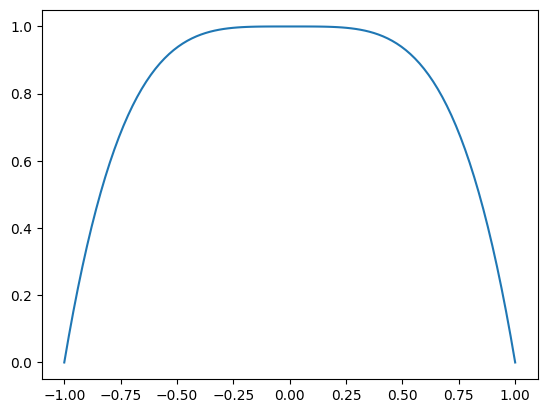

In [3]:
X = np.linspace(-1, 1, 100)
Y = f(X)

plt.plot(X, Y)

In [4]:
ux = cp.Uniform(-1, 1)

In [5]:
# create a gaussian quadrature rule with 100 nodes and weights
nodes, weights = cp.generate_quadrature(5, ux, rule="G")

# sample the function at the nodes
samples_f = [f(node) for node in nodes.T]

# create a polynomial expansion of the samples
P = cp.expansion.stieltjes(5, ux)

# fit the polynomial to the samples
f_hat = cp.fit_quadrature(P, nodes, weights, samples_f)

mean = cp.E(f_hat ,ux)
var = cp.Var(f_hat, ux)

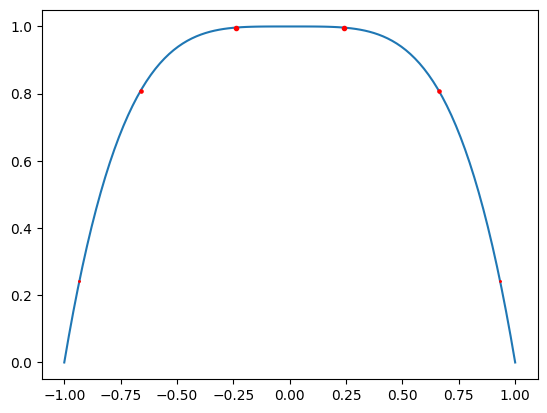

In [6]:
X = np.linspace(-1, 1, 100)
Y = f(X)
Y_nodes = f(nodes[0])

weights = weights / np.max(weights)

# plot the gaussian quadrature node and weights
plt.plot(X, Y)
for x, y, w in zip(nodes[0], Y_nodes, weights):
    plt.plot(x, y, 'o', c="red", markersize=w*3)

In [10]:
def create_pce(ux, num_nodes, order, function):
    # create a gaussian quadrature rule with 100 nodes and weights
    nodes, weights = cp.generate_quadrature(num_nodes, ux, rule="G")

    # sample the function at the nodes
    samples_f = [function(node) for node in nodes.T]

    # create a polynomial expansion of the samples
    P = cp.expansion.stieltjes(order, ux)

    # fit the polynomial to the samples
    f_hat = cp.fit_quadrature(P, nodes, weights, samples_f)

    return f_hat

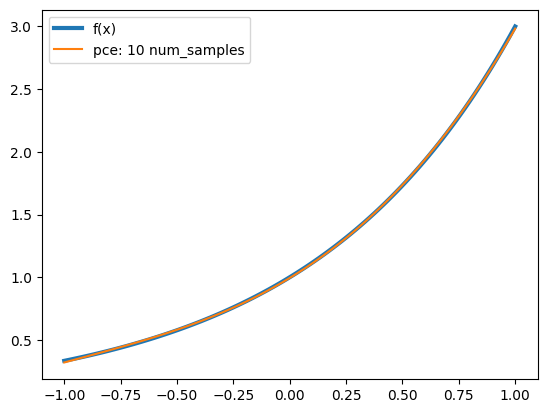

In [11]:
def f_(x):
    return 3**x

ux = cp.Uniform(-1, 1)

X = np.linspace(-1, 1, 100)
Y = f_(X)

plt.plot(X, Y, label="f(x)", linewidth=3)

for num_samples in [10]:
    #X_samples = np.random.uniform(-1, 1, num_samples)

    f_hat = create_pce(ux, num_samples, 3, f_)
    Y_hat = f_hat(X).squeeze()
    plt.plot(X, Y_hat, label=f"pce: {num_samples} num_samples")

plt.legend()

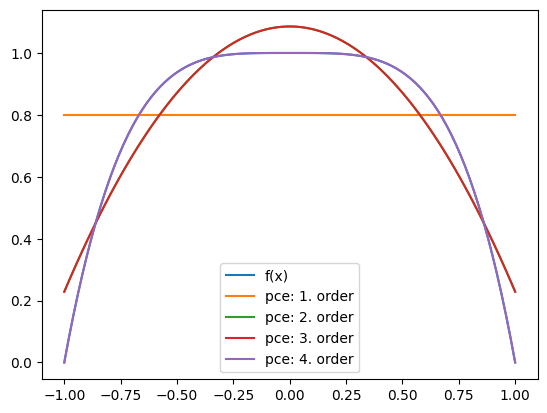

In [12]:
ux = cp.Uniform(-1, 1)

X = np.linspace(-1, 1, 100)
Y = f(X)

plt.plot(X, Y, label="f(x)")

for order in range(1, 5):
    f_hat = create_pce(ux, 10, order, f)
    Y_hat = f_hat(X).squeeze()
    plt.plot(X, Y_hat, label=f"pce: {order}. order")

plt.legend()

## Plot the PCE result

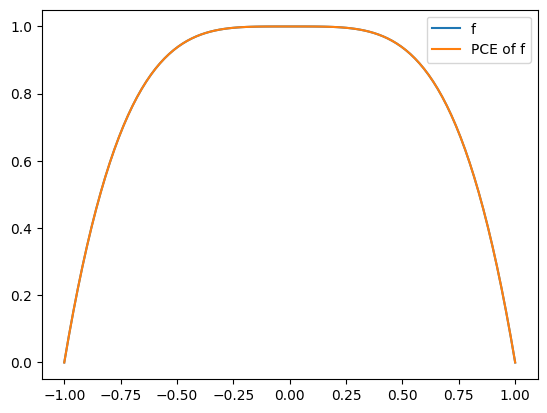

In [13]:
X = np.linspace(-1, 1, 100)
Y_hat = f_hat(X).squeeze()
Y = f(X)

_ = plt.plot(X, Y, label="f")
_ = plt.plot(X, Y_hat, label="PCE of f")
plt.legend()

## Fitting a Gaussian Process to the same function

In [44]:
# define the gaussian kernel
def gaussian_kernel(x, y, sigma=1, l=1):
    return l * np.exp(-(x-y)**2 / (2*sigma**2))

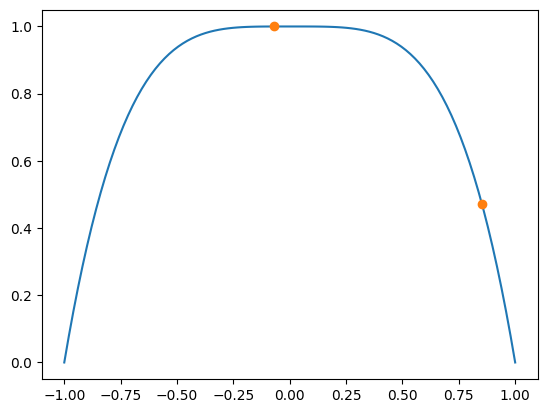

In [47]:
# generate samples
X_samples = np.random.uniform(-1, 1, 2)
Y_samples = f(X_samples)

plt.plot(X, Y)
plt.plot(X_samples, Y_samples, 'o')

In [33]:
X_eval = np.linspace(-1, 1, 100)

\begin{align*}
\Sigma &= k(X,X)+\sigma^2 I\\
\Sigma_\star &= k(X,X_\star)\\
\Sigma_{\star\star} &= k(X_\star,X_\star)+\sigma^2 I
\end{align*}

In [57]:
corr_inv = np.linalg.inv(gaussian_kernel(X_samples[:, None], X_samples[None, :], l=0.1))
corr_star = gaussian_kernel(X_samples[:, None], X_eval[None, :], l=0.1)
corr_star_star = gaussian_kernel(X_eval[:, None], X_eval[None, :], l=0.1)

\begin{equation}
\mathbf{f}_\star | \mathbf{f} \sim \mathcal{N} (
\underbrace{\Sigma_\star^\top \Sigma^{-1} \mathbf{f}}_{\boldsymbol{\mu}_\star}
~,~
\underbrace{\Sigma_{\star\star} - \Sigma_\star^\top \Sigma^{-1} \Sigma_\star}_{C_\star}
)
\end{equation}

In [58]:
mean = corr_star.T @ corr_inv @ Y_samples
covar = corr_star_star - corr_star.T @ corr_inv @ corr_star
var = np.diag(covar)

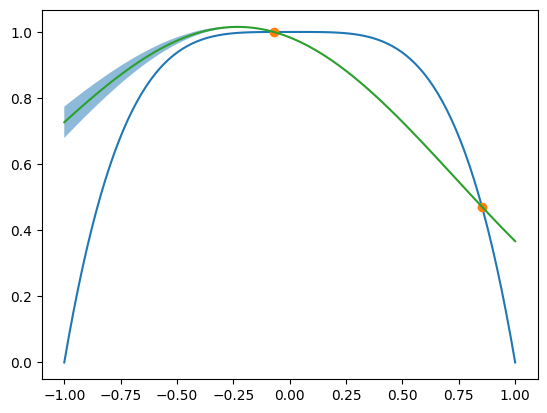

In [59]:
plt.plot(X, Y)
plt.plot(X_samples, Y_samples, 'o')
plt.plot(X_eval, mean)
plt.fill_between(X_eval, mean - var, mean + var, alpha=0.5)

# Uncertainty in paramters

We have seen how to approximate any univariate function with a PCE where the input x is uncertain.
Now we look at how we can construct a PCE for a function who's parameters lie in uncertainty.

## Univariate Case

### Define the function to approximate

In [39]:
# define input samples domain
coordinates = np.linspace(0, 10, 1000)

# define decay function with input and an alpha parameter
def f(alpha, x=coordinates):
    return -(x-2) * (x-alpha) + 10

In [40]:
# define alpha to be normally distributed with mean 5 and std 0.8
alpha = cp.Normal(5, .8)

### Plot the samples

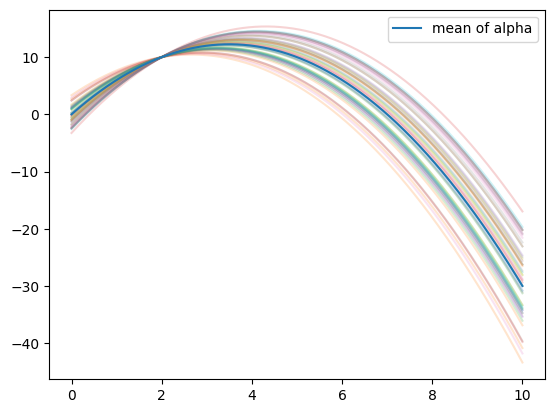

In [41]:
# sample 50 times from alpha and plot the resulting function over the domain
for _ in range(50):
    a = alpha.sample()
    plt.plot(coordinates, f(a), alpha=0.2)

# plot the mean of the function over the domain
plt.plot(coordinates, f(5), label="mean of alpha")

plt.legend()
plt.show()

This is a heuristic approach to visualize the variance of the output distribution when the functions parameter have some uncertainty.

### Create Polynomial Chaos Expansion

In [42]:
# create a gaussian quadrature rule with 3 nodes and weights
nodes, weights = cp.generate_quadrature(3, alpha, rule="G")

# sample the function at the nodes
samples_f = [f(node) for node in nodes.T]

# create a polynomial expansion of the samples
P = cp.expansion.stieltjes(2, alpha)

# fit the polynomial to the samples
f_hat = cp.fit_quadrature(P, nodes, weights, samples_f)

mean = cp.E(f_hat ,alpha)
var = cp.Var(f_hat, alpha)

### Plot results

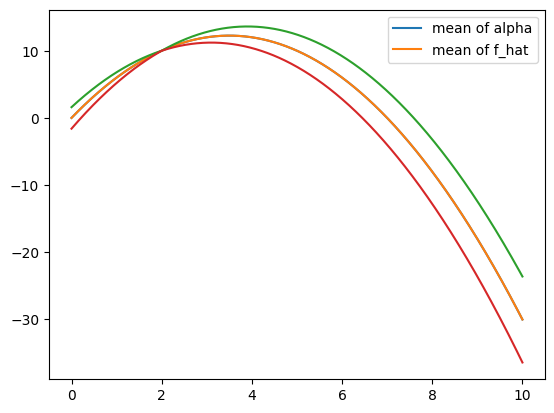

In [43]:
plt.plot(coordinates, f(5), label="mean of alpha")
plt.plot(coordinates, mean, label="mean of f_hat")
plt.plot(coordinates, mean+np.sqrt(var))
plt.plot(coordinates, mean-np.sqrt(var))

plt.legend()
plt.show()

We see that the mean optained by PCE is exactly the real one. Also, the variance is very similar to the Monte Carlo simultaions previously.

## Multivariate Case

This time, the function to approximate has two uncertain parameters and we seek to build a PCE for their joint distribtion.

### Define a function

In [15]:
# define input samples domain
coordinates = np.linspace(0, 10, 1000)

# define function, this time with a alpha and beta parameter
def f(params, x=coordinates):
    alpha, beta = params
    return -(x-2) * (x-alpha) + beta

In [16]:
# alpha is uniformly distributed between 4 and 5
alpha = cp.Uniform(4, 5)

# beta is normally distributed with mean 10 and std 2
beta = cp.Normal(10, 2)

# define the joint distribution of alpha and beta
joint = cp.J(alpha, beta)

### Plot samples

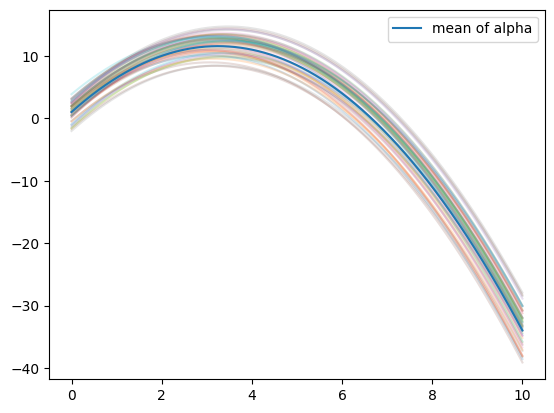

In [17]:
# sample 50 times from the joint distribution and plot the resulting function over the domain
for _ in range(50):
    d = joint.sample()
    plt.plot(coordinates, f(d), alpha=0.2)

# plot the mean of the function over the domain
plt.plot(coordinates, f((4.5, 10)), label="mean of alpha")

plt.legend()
plt.show()

In [18]:
# create a gaussian quadrature rule with 3 nodes and weights
nodes, weights = cp.generate_quadrature(3, joint, rule="G")

# sample the function at the nodes
samples_f = [f(node) for node in nodes.T]

# create a polynomial expansion of the samples
P = cp.expansion.stieltjes(2, joint)

# fit the polynomial to the samples
f_hat = cp.fit_quadrature(P, nodes, weights, samples_f)

mean = cp.E(f_hat , joint)
var = cp.Var(f_hat, joint)

### Plot results

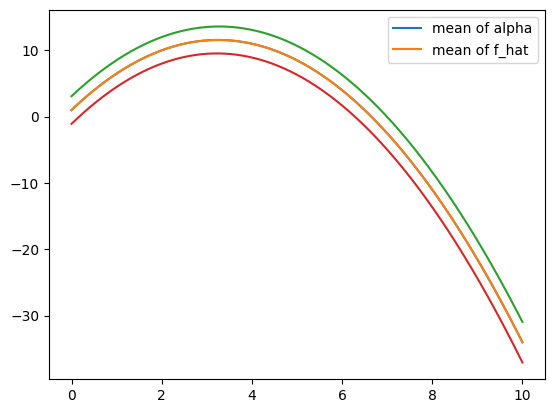

In [19]:
plt.plot(coordinates, f((4.5, 10)), label="mean of alpha")
plt.plot(coordinates, mean, label="mean of f_hat")
plt.plot(coordinates, mean+np.sqrt(var))
plt.plot(coordinates, mean-np.sqrt(var))

plt.legend()
plt.show()

# Print Hermite Polynomials

In [20]:
# function that plots the hermite polynomials from numpy
def plot_hermite_polynomials(n, x, thickness):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    ax = plt.gca()
    #ax.set_visible(False)
    
    for i in range(n):
        plt.plot(x, np.polynomial.hermite.hermval(x, [0]*i+[1]), color=colors[i], linewidth=thickness)
        plt.grid(False)
    
    
    plt.xticks([])
    plt.yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #plt.show()
    plt.savefig(f"hermite_polynomials.png", transparent=True, bbox_inches='tight')
    plt.close()

thickness = 2
#for i in range(5):
plot_hermite_polynomials(5, np.linspace(-1.8, 1.8, 1000), thickness)



In [21]:
# print out the hermite polynomial equations of order n
def print_hermite_polynomials(n):
    for i in range(n):
        print(np.polynomial.hermite.Hermite([0]*i+[1]))

print_hermite_polynomials(5)

1.0
0.0 + 1.0·H₁(x)
0.0 + 0.0·H₁(x) + 1.0·H₂(x)
0.0 + 0.0·H₁(x) + 0.0·H₂(x) + 1.0·H₃(x)
0.0 + 0.0·H₁(x) + 0.0·H₂(x) + 0.0·H₃(x) + 1.0·H₄(x)
